http://www.ipeadata.gov.br/

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [181]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

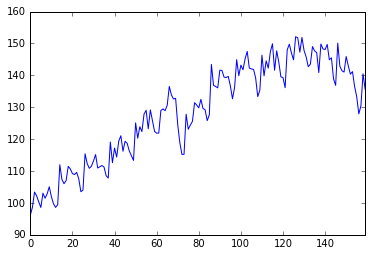

In [182]:
dataset = pd.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataset.columns = ['DATA','IBC_BR']
dataset['IBC_BR'].plot()

In [229]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, activity_l2

from sklearn.metrics import r2_score

In [184]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [185]:
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataframe.columns = ['DATA','IBC_BR']
#dataset = dataframe['IBC_BR'].values.reshape(-1, 1)
#dataset = dataset.astype('float32')

### Add trend and seasonal factor

In [186]:
seasonal = pd.get_dummies(dataframe['DATA'].apply(lambda x: int(str(x).split('.')[-1])))
seasonal.columns = ['D'+str(x) for x in range(1,12)]

In [187]:
data = pd.concat([dataframe, seasonal], axis=1)
data['TREND'] = range(0, dataframe.shape[0])

In [188]:
data['LAG_IBC_BR'] = data.groupby(['DATA'])['IBC_BR'].mean().shift(1).reset_index(drop=True)

In [189]:
data = data.rename(columns={'IBC_BR':'TARGET'})

In [190]:
data = data.fillna(0)

In [191]:
del data['DATA']

In [192]:
data['perc_TARGET'] = data['TARGET']/data['LAG_IBC_BR']-1
data.ix[np.isinf(data['perc_TARGET']),'perc_TARGET'] = 0
target = data['TARGET']
del data['TARGET']

In [193]:
# convert an array of values into a dataset matrix
def create_dataset(df, ratio=0.67):
    
    train_size = int(len(data) * ratio)
    test_size = len(data) - train_size
    train, test = data.loc[0:train_size,:], data.loc[train_size:len(data),:]
    
    trainX, trainY = [], []
    trainY = train['perc_TARGET']
    trainX = train.ix[:, train.columns != 'perc_TARGET']

    testX, testY = [], []
    testY = test['perc_TARGET']
    testX = test.ix[:, test.columns != 'perc_TARGET']
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainX = scaler.fit_transform(trainX)
    
#    trainX = scale(trainX)
    testX = scaler.transform(testX)
    

    return np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [194]:
trainX, trainY, testX, testY = create_dataset(data)

In [195]:
print(trainX.shape, testX.shape)

((108, 13), (53, 13))


In [196]:
trainX.shape[1]

13

In [197]:
df_tra = pd.DataFrame(trainX)
df_tra['sample'] = 1
df_tra['t'] = range(54)+range(54)

In [198]:
df_tra['sample'][54:] = 2

/home/sandor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [199]:
trainX = pd.melt(df_tra, id_vars=['sample','t']).groupby(['sample','t','variable']).sum()
trainX.values[np.newaxis,:,:].shape

(1, 1404, 1)

In [200]:
df_tra.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,sample,t
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009346,0.651820,1,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018692,0.668904,1,2
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028037,0.701037,1,3
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037383,0.692767,1,4


In [201]:
samples = len(df_tra['sample'].unique())
time = len(df_tra['t'].unique())
feats = df_tra.shape[1]-2
base = numpy.zeros((samples,time,feats))

In [202]:
for i in range(samples):
    for j in range(time):
        for z in range(feats):
            base[i][j][z] = df_tra.loc[j,z]

In [203]:
trainX = base

In [204]:
trainX.shape

(2, 54, 13)

# check this

http://stackoverflow.com/questions/36992855/keras-how-should-i-prepare-input-data-for-rnn

In [100]:
# reshape input to be [samples, time steps, features]
#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#trainX = numpy.reshape(trainX, (1, trainX.shape[0], trainX.shape[1]))
#testX = numpy.reshape(testX, (1, testX.shape[0], testX.shape[1]))

In [18]:
# import numpy as np
# from keras import backend as K
# def mean_squared_error(y_true, y_pred):
#     return K.mean(K.square(y_true - y_pred), axis=-1)

# def rsquared(y_true, y_pred):
#     ssres = K.mean(K.square(y_true - y_pred), axis=-1)
#     sstot = K.square(y_true -K.mean(y_true))
#     rsquare = (1 - (ssres/sstot))
#     return rsquare

# def sum_squared_error(y_true, y_pred):
#     return K.sum(K.square(y_true - y_pred), axis=-1)

In [220]:
trainY = np.array([trainY[:54],trainY[54:]])
trainY.shape

(2, 54)

In [290]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(54, 13)))
#model.add(Dropout(0.2))
#model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(12))
#model.add(Flatten())
model.add(Dense(54, W_regularizer=l2(1e-6), activity_regularizer=activity_l2(1e-6)))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

hist = model.fit(trainX, trainY, nb_epoch=60, batch_size=1, verbose=2, validation_split=0.3)

Train on 1 samples, validate on 1 samples
Epoch 1/60
0s - loss: 0.0329 - val_loss: 0.0131
Epoch 2/60
0s - loss: 0.0113 - val_loss: 0.0055
Epoch 3/60
0s - loss: 0.0054 - val_loss: 0.0074
Epoch 4/60
0s - loss: 0.0042 - val_loss: 0.0058
Epoch 5/60
0s - loss: 0.0034 - val_loss: 0.0050
Epoch 6/60
0s - loss: 0.0025 - val_loss: 0.0046
Epoch 7/60
0s - loss: 0.0021 - val_loss: 0.0046
Epoch 8/60
0s - loss: 0.0013 - val_loss: 0.0034
Epoch 9/60
0s - loss: 4.6024e-04 - val_loss: 0.0035
Epoch 10/60
0s - loss: 2.1318e-04 - val_loss: 0.0035
Epoch 11/60
0s - loss: 1.4038e-04 - val_loss: 0.0035
Epoch 12/60
0s - loss: 1.1294e-04 - val_loss: 0.0036
Epoch 13/60
0s - loss: 1.0072e-04 - val_loss: 0.0036
Epoch 14/60
0s - loss: 1.0040e-04 - val_loss: 0.0036
Epoch 15/60
0s - loss: 1.1175e-04 - val_loss: 0.0037
Epoch 16/60
0s - loss: 1.5561e-04 - val_loss: 0.0036
Epoch 17/60
0s - loss: 2.5946e-04 - val_loss: 0.0042
Epoch 18/60
0s - loss: 5.2436e-04 - val_loss: 0.0038
Epoch 19/60
0s - loss: 6.4022e-04 - val_loss:

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

In [ ]:
trainPredict.shape

In [ ]:
trainPredictPlot = np.zeros((data.shape[0],1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[0:108,0] = list(trainPredict[0]) + list(trainPredict[1])

#testPredictPlot = np.zeros((data.shape[0],1))
#testPredictPlot[:,:] = np.nan
#testPredictPlot[-len(testPredict):len(data),:] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(data['perc_TARGET'])
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)

In [ ]:
plotTrain = (1+trainPredictPlot[:,0])*data['LAG_IBC_BR']
#plotTest = (1+testPredictPlot[:,0])*data['LAG_IBC_BR']

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
#plt.plot(data['perc_TARGET'])
plt.plot(target)
plt.plot(plotTrain)
#plt.plot(plotTest)
plt.ylim(95,160)

In [ ]:
train_r2 = round(r2_score(target[1:108], plotTrain[1:108]),2)
#test_r2 = round(r2_score(target[-len(testPredict):len(plotTest)],plotTest[-len(testPredict):len(plotTest)]),2)
print 'Train R2 - %s' % train_r2#, ' / ','Test R2 - %s' % test_r2
